In [2]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Fairlearn - for disparity metrics
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import false_positive_rate, true_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.datasets import fetch_diabetes_hospital
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score



In [3]:
# =====================================================
# Synthetic Data Setup 
# =====================================================


data = fetch_diabetes_hospital()
X_raw = data.data   
Y = data.target     


df = X_raw.copy()
df["target"] = Y

# Downsampling
df_sampled, _ = train_test_split(
    df, 
    train_size=8000, 
    random_state=42, 
    stratify=df["race"]  # Ensuring class distribution is maintained
)
drop_candidates = ["readmitted", "readmit_binary", "target"] # Drop these columns since they are directly related to the target

# Separate features, labels, and sensitive attribute
Y_downsampled = df_sampled["target"]
A_downsampled = df_sampled["race"]          # Protected attribute
X_downsampled = df_sampled.drop(columns=drop_candidates)

# Check shapes
print("X_downsampled shape:", X_downsampled.shape)
print("Y_downsampled shape:", Y_downsampled.shape)
print("A_downsampled shape:", A_downsampled.shape)

X_downsampled shape: (8000, 22)
Y_downsampled shape: (8000,)
A_downsampled shape: (8000,)


<BarContainer object of 6 artists>

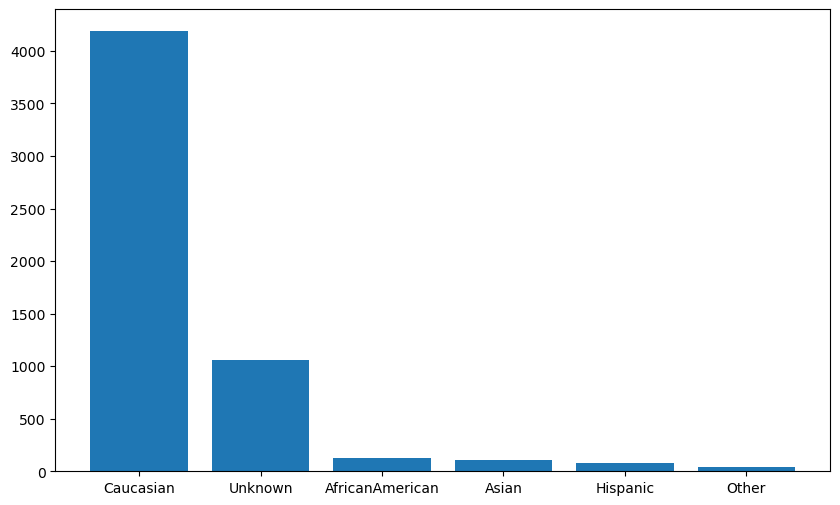

In [10]:
from matplotlib import pyplot as plt
### Distribution of sensitive attribute
plt.figure(figsize=(10, 6))
plt.bar(A_train.unique(), A_train.value_counts().values)

In [5]:
cat_cols = X_downsampled.select_dtypes(include=["object", "category"]).columns
enc = OneHotEncoder(sparse_output=False)
X_cat_array = enc.fit_transform(X_downsampled[cat_cols])
encoded_col_names = enc.get_feature_names_out(cat_cols)

In [6]:
X_cat_df = pd.DataFrame(X_cat_array, 
                        columns=encoded_col_names, 
                        index=X_downsampled.index)

# Merge one-hot encoded features with numeric columns
X_encoded = pd.concat([X_downsampled.drop(columns=cat_cols), X_cat_df], axis=1)
print(f"Shape before encoding: {X_downsampled.shape}")
print(f"Shape after encoding:  {X_encoded.shape}")

Shape before encoding: (8000, 22)
Shape after encoding:  (8000, 58)


[0]	validation_0-aucpr:0.14285
[1]	validation_0-aucpr:0.14340
[2]	validation_0-aucpr:0.14393
[3]	validation_0-aucpr:0.14340
[4]	validation_0-aucpr:0.14387
[5]	validation_0-aucpr:0.14393
[6]	validation_0-aucpr:0.14505
[7]	validation_0-aucpr:0.14474
[8]	validation_0-aucpr:0.14380
[9]	validation_0-aucpr:0.14532
[10]	validation_0-aucpr:0.14552
[11]	validation_0-aucpr:0.14453
[12]	validation_0-aucpr:0.14455
[13]	validation_0-aucpr:0.14401
[14]	validation_0-aucpr:0.14357
[15]	validation_0-aucpr:0.14430
[16]	validation_0-aucpr:0.14388
[17]	validation_0-aucpr:0.14308
[18]	validation_0-aucpr:0.14279
[19]	validation_0-aucpr:0.14409
[20]	validation_0-aucpr:0.14502
[21]	validation_0-aucpr:0.14466
[22]	validation_0-aucpr:0.14517
[23]	validation_0-aucpr:0.14511
[24]	validation_0-aucpr:0.14544
[25]	validation_0-aucpr:0.14499
[26]	validation_0-aucpr:0.14442
[27]	validation_0-aucpr:0.14460
[28]	validation_0-aucpr:0.14383
[29]	validation_0-aucpr:0.14410
[30]	validation_0-aucpr:0.14445
[31]	validation_0-

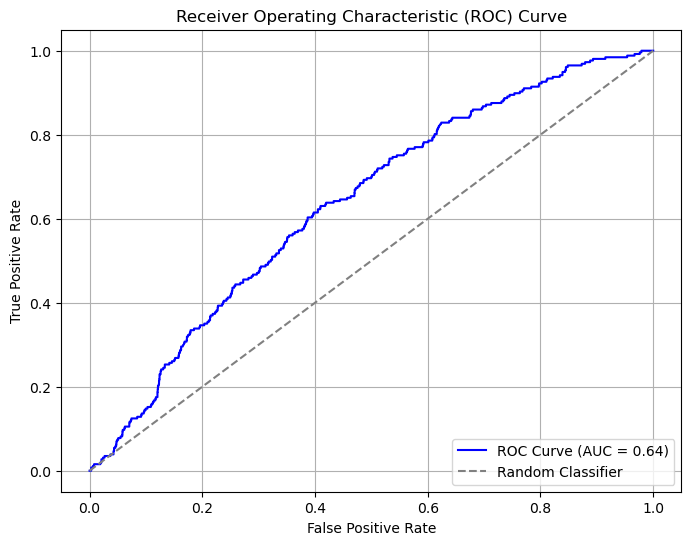

In [ ]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_encoded, 
    Y_downsampled, 
    A_downsampled, 
    test_size=0.3, 
    random_state=42, 
    stratify=A_downsampled
)

# =====================================================
# Train XGBoost Model
# =====================================================
from collections import Counter

# Calculate the scale_pos_weight
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]


model = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.01,
    n_estimators=250,
    max_depth=4,          
    min_child_weight=5,   
    gamma=1,             
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
)
# model = XGBClassifier(
#     objective="binary:logistic",
#     learning_rate=0.01,
#     n_estimators=200,
#     max_depth=4,          
#     min_child_weight=3,   
#     gamma=1,             
#     eval_metric="aucpr",
#     scale_pos_weight=7.9,
# )



model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True # Set to True to see progress each round
)

### Evaluate on training data
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")
#  Evaluate on Test Data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

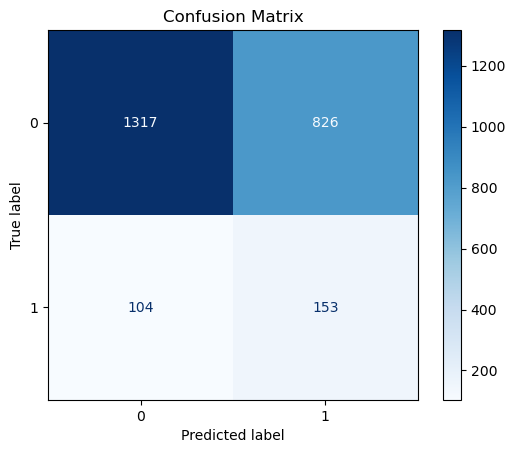

Accuracy: 0.61
Precision: 0.16
Recall: 0.60
F1 Score: 0.25


In [88]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')



In [99]:
def evaluate_fairness_one_vs_rest(model, X_test, y_test, A_test):
    """
    For each unique group in A_test, treat that group as '1'
    and the rest as '0'. Then compute:
      - TPR, FPR (for Equalized Odds)
      - Precision, Recall
      - Absolute & Non-Absolute Differences
    """
    # Predictions from your trained model
    y_pred = model.predict(X_test)

    unique_groups = A_test.unique()
    
    # We'll store results in a list of dictionaries for neat output
    results = []
    
    for group_val in unique_groups:
        # Create a binary sensitive feature: 1 if A == group_val, else 0
        A_bin = (A_test == group_val).astype(int)

        # Build a MetricFrame for these two "groups" => 1 vs. 0
        metrics_dict = {
            "TPR": true_positive_rate,
            "FPR": false_positive_rate,
            "Precision": precision_score,
            "Recall": recall_score,
        }
        
        mf = MetricFrame(
            metrics=metrics_dict,
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=A_bin
        )

        # By-group values (we have up to 2 groups: {0, 1})
        by_group = mf.by_group  # a DataFrame with metrics for group 0 and 1

        # If for some reason the group doesn't appear in test, skip
        if len(by_group) < 2:
            # Means all test examples are from one group
            continue

        tpr_g, tpr_r = by_group.loc[1, "TPR"], by_group.loc[0, "TPR"]
        fpr_g, fpr_r = by_group.loc[1, "FPR"], by_group.loc[0, "FPR"]
        prec_g, prec_r = by_group.loc[1, "Precision"], by_group.loc[0, "Precision"]
        rec_g, rec_r = by_group.loc[1, "Recall"], by_group.loc[0, "Recall"]

        # Non-absolute differences (group - rest)
        tpr_diff_nonabs = tpr_g - tpr_r
        fpr_diff_nonabs = fpr_g - fpr_r
        prec_diff_nonabs = prec_g - prec_r
        rec_diff_nonabs = rec_g - rec_r

        # Absolute differences
        tpr_diff_abs = abs(tpr_diff_nonabs)
        fpr_diff_abs = abs(fpr_diff_nonabs)
        prec_diff_abs = abs(prec_diff_nonabs)
        rec_diff_abs = abs(rec_diff_nonabs)
        


        # Collect the results for this group
        results.append({
            "Group": group_val,
            "group_size": (A_bin == 1).sum(),
            "eq_odds_prec": prec_g,
            "eq_odds_recall": prec_r,
            "TPR_diff_abs": tpr_diff_abs,
            "FPR_diff_abs": fpr_diff_abs,
            "Prec_diff_abs": prec_diff_abs,
            "Recall_diff_abs": rec_diff_abs,
            "TPR_diff_nonabs": tpr_diff_nonabs,
            "FPR_diff_nonabs": fpr_diff_nonabs,
            "Prec_diff_nonabs": prec_diff_nonabs,
            "Recall_diff_nonabs": rec_diff_nonabs,
        
        })

    # Convert list of dicts to DataFrame for a nicer format
    results_df = pd.DataFrame(results)
    return results_df


In [100]:
evaluate_fairness_one_vs_rest(model, X_test, y_test, A_test)    

,Group,group_size,eq_odds_prec,eq_odds_recall,TPR_diff_abs,FPR_diff_abs,Prec_diff_abs,Recall_diff_abs,TPR_diff_nonabs,FPR_diff_nonabs,Prec_diff_nonabs,Recall_diff_nonabs
0,Caucasian,1795,0.156611,0.155000,0.090738,0.101873,0.001611,0.090738,0.090738,0.101873,0.001611,0.090738
1,AfricanAmerican,453,0.156627,0.156212,0.021279,0.052252,0.000415,0.021279,-0.021279,-0.052252,0.000415,-0.021279
2,Other,35,0.285714,0.154404,0.073041,0.041171,0.131310,0.073041,0.073041,-0.041171,0.131310,0.073041
3,Unknown,54,0.000000,0.157407,0.602362,0.254236,0.157407,0.602362,-0.602362,-0.254236,-0.157407,-0.602362
4,Hispanic,48,0.111111,0.156701,0.350791,0.207891,0.045590,0.350791,-0.350791,-0.207891,-0.045590,-0.350791
5,Asian,15,0.000000,0.156923,0.597656,0.100382,0.156923,0.597656,-0.597656,-0.100382,-0.156923,-0.597656


In [105]:

def compute_macro_recall(y_true, y_pred, A_test):
    
    df = pd.DataFrame({
        'race': A_test,
        'true_label': y_true,
        'predicted_label': y_pred
    })

    # Compute recall for each race
    recall_per_race = df.groupby('race').apply(lambda x: recall_score(x['true_label'], x['predicted_label']))
    # Compute Macro Recall (Average across all races)
    macro_recall = recall_per_race.mean()

    return macro_recall



    
    

Recall per race:
 race
Asian    1.000000
Black    1.000000
White    0.666667
dtype: float64

Macro Recall (Average across races): 0.8888888888888888


C:\Users\jx\AppData\Local\Temp\ipykernel_21824\497146793.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recall_per_race = df.groupby('race').apply(lambda x: recall_score(x['true_label'], x['predicted_label']))
